In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1657982041.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [4]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D,
    BatchNormalization, Activation, Add, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Dropout, Reshape, Multiply, concatenate,
    Lambda
)
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def _compute_spatial_output_shape(input_shape):
    return (input_shape[0], input_shape[1], 1)

def cbam_resnet_block(input_tensor, filters, kernel_size, reduction_ratio=8):
    x = Conv1D(filters, kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    channels = x.shape[-1]

    avg_pool_ch = GlobalAveragePooling1D()(x)
    max_pool_ch = GlobalMaxPooling1D()(x)

    avg_mlp = Dense(channels // reduction_ratio, activation='relu')(avg_pool_ch)
    avg_mlp = Dense(channels)(avg_mlp)

    max_mlp = Dense(channels // reduction_ratio, activation='relu')(max_pool_ch)
    max_mlp = Dense(channels)(max_mlp)

    channel_weights = Activation('sigmoid')(Add()([avg_mlp, max_mlp]))
    channel_weights = Reshape((1, channels))(channel_weights)

    x_channel_refined = Multiply()([x, channel_weights])

    avg_pool_sp = Lambda(lambda t: K.mean(t, axis=-1, keepdims=True),
                         output_shape=_compute_spatial_output_shape)(x_channel_refined)
    max_pool_sp = Lambda(lambda t: K.max(t, axis=-1, keepdims=True),
                         output_shape=_compute_spatial_output_shape)(x_channel_refined)

    concat_sp = concatenate([avg_pool_sp, max_pool_sp], axis=-1)

    spatial_weights = Conv1D(1, kernel_size=7, padding='same', activation='sigmoid')(concat_sp)

    x_final_refined = Multiply()([x_channel_refined, spatial_weights])

    if input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    output_block = Add()([x_final_refined, shortcut])
    output_block = Activation('relu')(output_block)

    return output_block

inputs = Input(shape=(n_timesteps, n_features))

x = Conv1D(64, 7, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = cbam_resnet_block(x, 64, kernel_size=3)
x = cbam_resnet_block(x, 64, kernel_size=3)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = cbam_resnet_block(x, 128, kernel_size=3)
x = cbam_resnet_block(x, 128, kernel_size=3)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

cbam_senet_model = Model(inputs, outputs)

cbam_senet_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

cbam_senet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │      4,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 64, 64)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 64, 64)    │     12,352 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 64, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        520 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        576 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │        576 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64)        │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 273,118 (1.04 MB)

 Trainable params: 271,198 (1.03 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
model_history_cbam = cbam_senet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.7603 - loss: 0.6719 - val_accuracy: 0.5235 - val_loss: 1.4344
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9333 - loss: 0.1737 - val_accuracy: 0.9443 - val_loss: 0.1387
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9452 - loss: 0.1454 - val_accuracy: 0.9361 - val_loss: 0.1425
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9376 - loss: 0.1518 - val_accuracy: 0.9443 - val_loss: 0.1429
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9484 - loss: 0.1233 - val_accuracy: 0.9449 - val_loss: 0.1194
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9479 - loss: 0.1342 - val_accuracy: 0.9497 - val_loss: 0.1219
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9465 - loss: 0.1296 - val_accuracy: 0.9551 - val_loss: 0.1074
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9485 - loss: 0.1292 - val_accuracy:

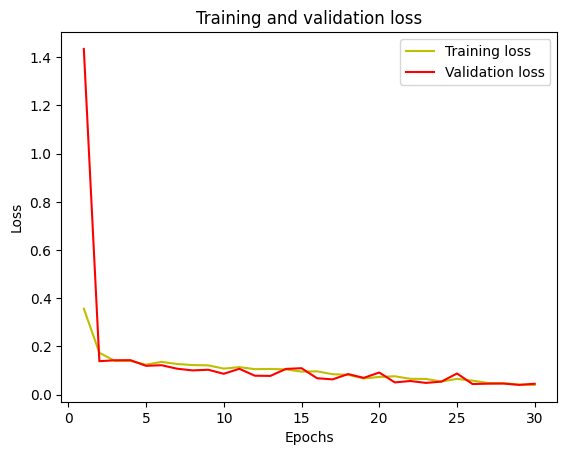

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history_cbam.history['loss']
val_loss =model_history_cbam.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

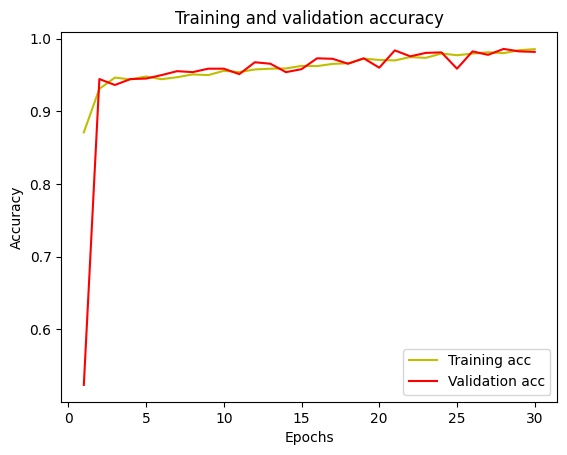

In [8]:
acc =model_history_cbam.history['accuracy']
val_acc =model_history_cbam.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
[[466   0  30   0   0   0]
 [  1 434  36   0   0   0]
 [  0   0 420   0   0   0]
 [  0   1   0 413  71   6]
 [  0   0   0  17 515   0]
 [  0   0   0   0   0 537]]
0.9450288428910757
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       1.00      0.92      0.96       471
           2       0.86      1.00      0.93       420
           3       0.96      0.84      0.90       491
           4       0.88      0.97      0.92       532
           5       0.99      1.00      0.99       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.94      2947
weighted avg       0.95      0.95      0.95      2947



<Axes: >

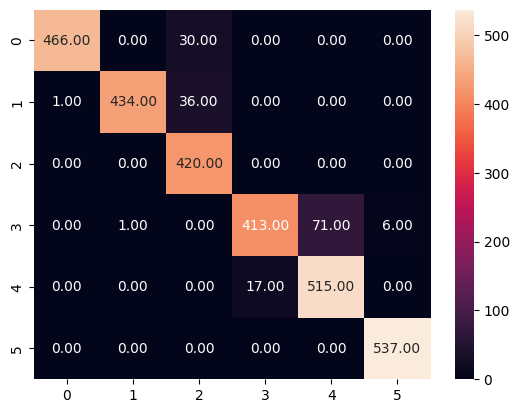

In [9]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cbam_senet_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')